In [1]:
# energyflow dependencies import
from __future__ import absolute_import, division, print_function
import tensorflow as tf
import keras.backend as K

# system modules
import sys
import os
import glob
import math 
import multiprocessing as mp
import gc

# standard numerical library imports
import numpy as np
from scipy import stats
from math import atan2
import matplotlib.pyplot as plt
import pandas as pd
from copy import copy
import csv
from numba import cuda # for memory management

# energyflow imports
from energyflow.archs import PFN
from energyflow.utils import data_split, to_categorical

# madgraph imports
sys.path.append('/tf/madgraph/MG5_aMC_v2_9_16') # inside docker
sys.path.append('/home/finn/madgraph/MG5_aMC_v2_9_16') # running locally
try:
    from madgraph.various.lhe_parser import FourMomentum, EventFile
except ModuleNotFoundError:
    print('Madgraph was not found in PATH or in docker /tf/madgraph/MG5_aMC_v2_9_16 dir \n can be added temporarily with sys.path.append(\'path/to/madgraph\')')

sys.path.append('../20240503')
import DCTR


2024-05-31 12:34:26.360433: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-05-31 12:34:26.360496: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def find_b_quarks(event, theta):
    '''
    is called by process_file for every event in its LHE file
    inherits filename, maxJetParts and theta from process_file and thus from convertLHE
    
    goes through an event particle by particle, adding the top, anti-top,
    as well as up to maxJetParts other quarks and gluons in an event to arrays.
    Calculates some properties for the particles, like phi and pseudorapidity and discards
    some particles and events if it comes to domainErrors.
    
    returns the eventVector with all particles including tt-pair of the event
    '''

    w = event.wgt
    p_b = FourMomentum(0, 0, 0, 0)
    p_b_bar = FourMomentum(0, 0, 0, 0)
    eta_b = 0
    eta_b_bar = 0
    event_vector = []
    count_eta = 0
    
    # particle processing
    for particle in event:  # loops through every particle in event
        # I only want b-quarks that are the decay product of the top quarks. I don't want the b quark that can be emitted as an extra parton
        if particle.pid == 5 or particle.pid == -5: # b and b_bar quarks
            if type(particle.mother1) is float: # not sure why, but sometimes gives 0.0 as mother1 or mother2. Ignoring these b quarks
                # print(particle.mother1)
                continue
            elif particle.mother1.pid == 6 or particle.mother1.pid == -6 and \
                 particle.mother2.pid == 6 or particle.mother2.pid == -6: # only if they are the decay product of t or t_bar
                    # print(f'{particle.mother1.pid = }')
                    try: 
                        eta = DCTR.pseudorapidity(particle)
                    except: 
                        print('Problem Calculating eta for b quark, skipping event')
                        count_eta += 1
                        break
                    if particle.pid == 5: # only b
                        eta_b = eta
                        p_b = FourMomentum(particle)
                    elif particle.pid == -5: # only b_bar
                        eta_b_bar = eta
                        p_b_bar = FourMomentum(particle)

    # append to event output vector 
    event_vector.append([p_b.pt,     p_b.rapidity,     DCTR.phi(p_b),     p_b.mass,     eta_b,     p_b.E,      5, w, theta])  # add b     quark to output array
    event_vector.append([p_b_bar.pt, p_b_bar.rapidity, DCTR.phi(p_b_bar), p_b_bar.mass, eta_b_bar, p_b_bar.E, -5, w, theta])  # add b_bar quark to output array

    return event_vector, count_eta 
    


In [ ]:
def save_b_quarks_from_lhe(lhe_files, theta, labels):
    assert len(lhe_files) == len(labels), 'Lengths of lhe_files labels lists must be equal!'
    for i, file in enumerate(lhe_files):    
        lhe = EventFile(file) # uses madgraphs EventFile function to open the lhe file
        lhe_vector = []
        count_eta = 0
        for event in lhe: # goes through the lhe file, event by event
            event_vector, event_skipped = find_b_quarks(event, theta)
            lhe_vector.append(event_vector)
            count_eta += event_skipped

        print(f'Skipped {count_eta} events due to eta calculation errors')

        out_file = f'./output/{labels[i]}_b_quarks_from_lhe.npy'
        os.makedirs(os.path.dirname(out_file), exist_ok=True)
        print(f'Saving to file {out_file}')
        np.save(out_file, lhe_vector)

        del lhe, lhe_vector, count_eta # clear from memory after saving to disk



In [5]:
# save b quarks to files
'''
for i in range(10):
    MiNNLO_lhe_file = (f'/home/finn/Documents/BachelorThesis_Data/LHE/data/MiNNLO/0001-0500/pwgevents-{i+1:04d}.lhe')
    save_b_quarks_from_lhe(MiNNLO_lhe_file, theta=1, label=f'MiNNLO_{i+1:04d}')

hvq_lhe_file = '/home/finn/Documents/BachelorThesis_Data/LHE/data/POWHEG_new/BaseNom/Results100/pwgevents.lhe'

save_b_quarks_from_lhe(hvq_lhe_file, theta=0,label='hvq_100')
'''

Skipped 0 events due to eta calculation errors
Saving to file MiNNLO_0001_b_quarks_from_lhe.npy
Skipped 0 events due to eta calculation errors
Saving to file MiNNLO_0002_b_quarks_from_lhe.npy
Skipped 0 events due to eta calculation errors
Saving to file MiNNLO_0003_b_quarks_from_lhe.npy
Skipped 0 events due to eta calculation errors
Saving to file MiNNLO_0004_b_quarks_from_lhe.npy
Skipped 0 events due to eta calculation errors
Saving to file MiNNLO_0005_b_quarks_from_lhe.npy
Skipped 0 events due to eta calculation errors
Saving to file MiNNLO_0006_b_quarks_from_lhe.npy
Skipped 0 events due to eta calculation errors
Saving to file MiNNLO_0007_b_quarks_from_lhe.npy
Skipped 0 events due to eta calculation errors
Saving to file MiNNLO_0008_b_quarks_from_lhe.npy
Skipped 0 events due to eta calculation errors
Saving to file MiNNLO_0009_b_quarks_from_lhe.npy
Skipped 0 events due to eta calculation errors
Saving to file MiNNLO_0010_b_quarks_from_lhe.npy
Skipped 0 events due to eta calculation 

In [10]:
X1_b_quarks = []

for i in range(10):
        X1_b_quarks.extend(np.load(f'./output/MiNNLO_{i+1:04d}_b_quarks_from_lhe.npy'))
X1_b_quarks = np.array(X1_b_quarks)

print(np.shape(X1_b_quarks))

X0_b_quarks = np.load('./output/hvq_100_b_quarks_from_lhe.npy')[:100000]
print(np.shape(X0_b_quarks))

X1_wgt = X1_b_quarks[:,0,-2]
X0_wgt = X0_b_quarks[:,0,-2]


(100000, 2, 9)
(100000, 2, 9)


In [22]:
# convert single hvq lhe file for calculating the rwgt
# conversion and saving to disk only needs to be done once
'''
lhe_vector, _, _ = DCTR.process_file(hvq_lhe_file, maxJetParts = 0, theta = 0)
print(np.shape(lhe_vector))
np.save('./output/hvq_100_t_quarks_from_lhe.npy', lhe_vector)

nrm_array = np.load('../Data/POWHEG_hvq/13TeV/01-02_nrm_array.npz')['a']

lhe_vector_nrm, _ = DCTR.normalize_data(lhe_vector, nrm_array)
print(np.shape(lhe_vector_nrm))

np.save('./output/hvq_100_t_quarks_from_lhe_normalized.npy', lhe_vector_nrm)
'''


(1999777, 3, 9)
(1999777, 3, 9)


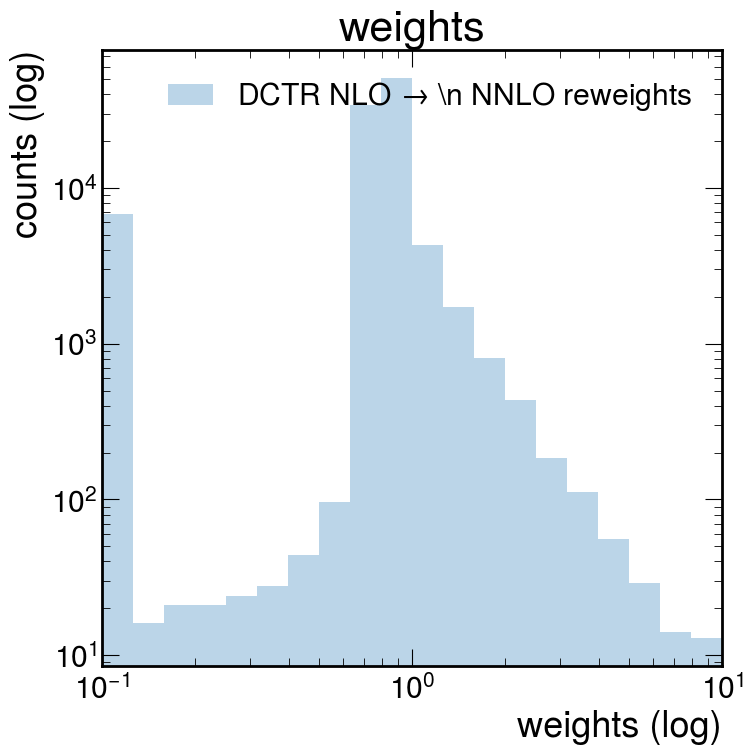

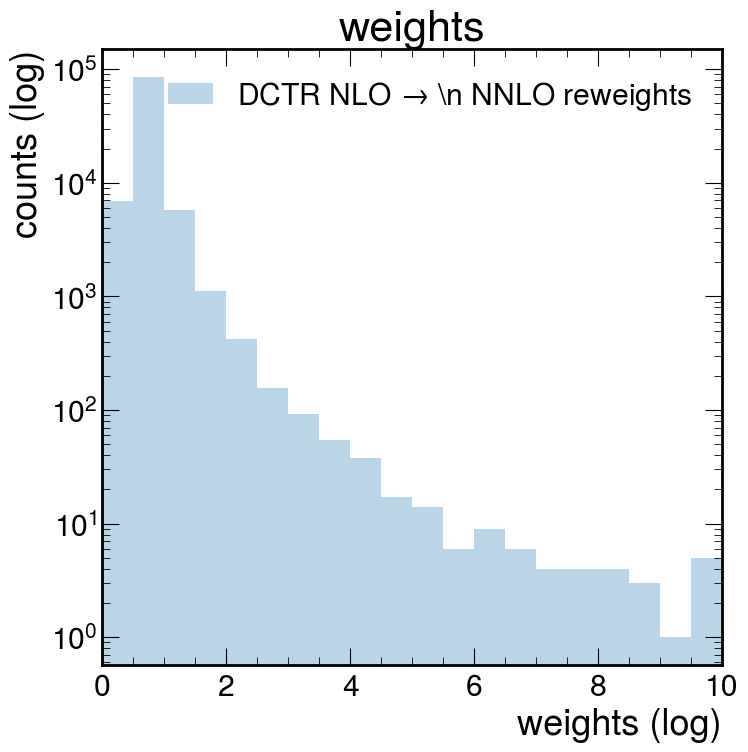

In [24]:
X1_nrm = np.load('./output/hvq_100_t_quarks_from_lhe_normalized.npy')[:100000]
X1_nrm = np.delete(X1_nrm, 5, -1) # delete E
X1_nrm = np.delete(X1_nrm, 4, -1) # delete eta

model = '../20240503/no-mean_training_best_model.tf' # path to previously trained model (in .tf format (folder))

# calculate rwgt
with tf.device('CPU'):
    dctr_rwgt = DCTR.get_rwgt([model], X1_nrm) # .tf models also include network architecture. get_rwgt() sets up the network for the (list of) models, then calls predict_weights() like in DCTR_notebook_OLD_14-to-13TeV notebook



# plot and check dctr rwgt
wgts = [(dctr_rwgt[0], r'DCTR NLO $\to$ \n NNLO reweights')]
DCTR.plot_weights(wgts, start = 0.1, stop = 10, div = 21) # log
DCTR.plot_weights(wgts, start = 0.0, stop = 10, xscale='lin', div = 21) # lin 

# apply orginal generator weights to rwgt
rwgt = np.multiply(dctr_rwgt[0], X0_wgt)


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


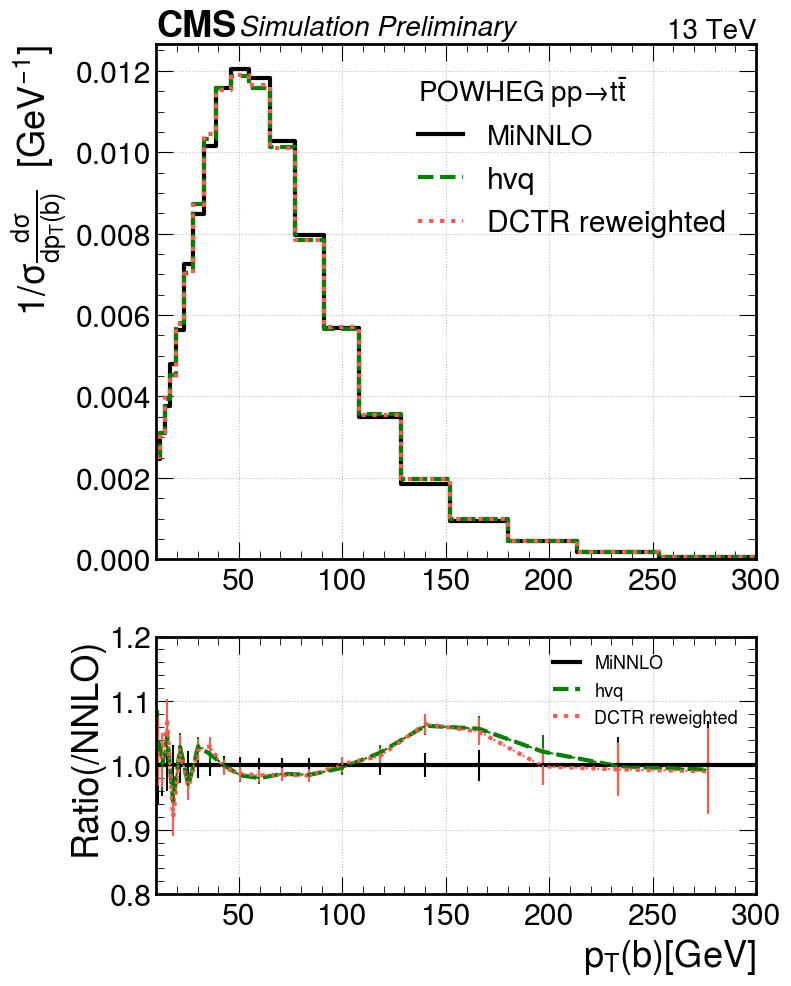

'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


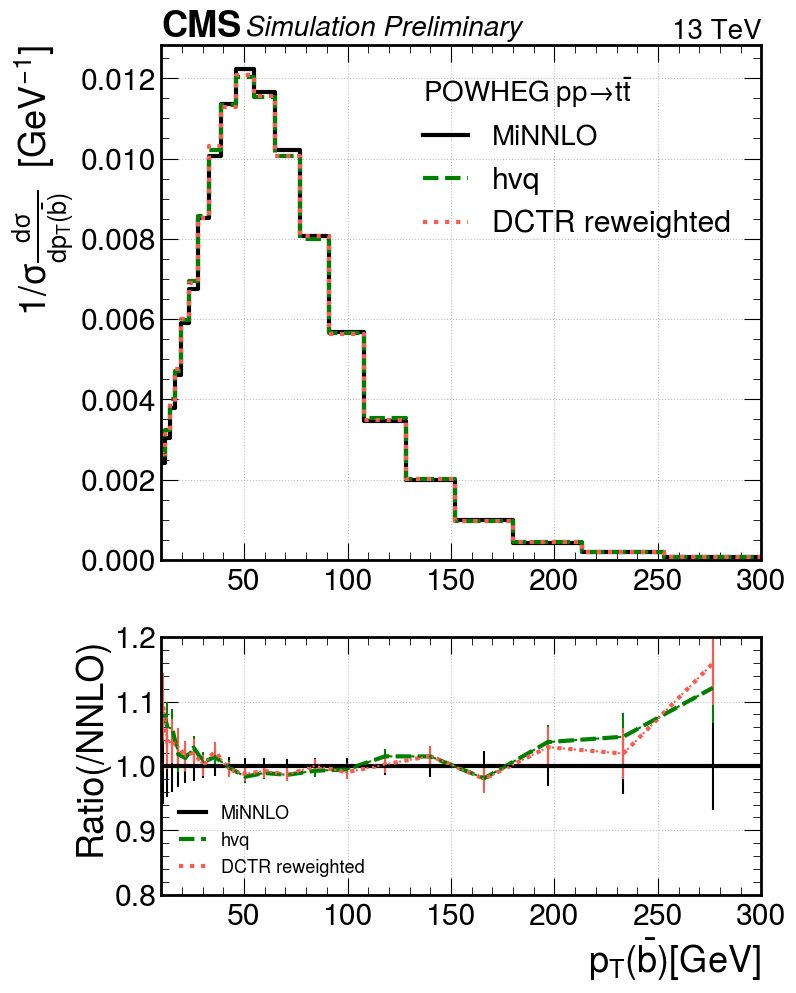

In [25]:
args = [(X1_b_quarks, X1_wgt, 'MiNNLO'),
        (X0_b_quarks, X0_wgt, 'hvq'),
        (X0_b_quarks, rwgt, 'DCTR reweighted')]


bins = np.logspace(np.log10(10), np.log10(300), 21)

DCTR.plot_ratio_cms(args, bins=bins, part_index=0, part_label=r'b', ratio_ylim=(0.8, 1.2))
DCTR.plot_ratio_cms(args, bins=bins, part_index=1, part_label=r'\bar{b}', ratio_ylim=(0.8, 1.2))
